# Цифровой прорыв 2023: Москва
#### Обучение и тестирование моделей Yolo

In [ ]:
!pip install ultralytics

In [2]:
import pandas as pd
import torch
from IPython.display import Image  # for displaying images
import os 
import random
import shutil
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from xml.dom import minidom
from tqdm import tqdm
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
import yaml

from ultralytics import YOLO

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Способ 1: Детекция

In [3]:
# https://blog.paperspace.com/train-yolov5-custom-data/

## Подготовка данных для детекции

In [4]:
class_name_to_id_mapping = {
    "klikun": 0,
    "small": 1,
    "shipun": 2,
}

In [5]:
# def extract_info_from_xml(xml_file):
#     root = ET.parse(xml_file).getroot()
    
#     # Initialise the info dict 
#     info_dict = {}
#     info_dict['bboxes'] = []

#     # Parse the XML Tree
#     for elem in root:
#         # Get the file name 
#         if elem.tag == "filename":
#             info_dict['filename'] = elem.text
            
#         # Get the image size
#         elif elem.tag == "size":
#             image_size = []
#             for subelem in elem:
#                 image_size.append(int(subelem.text))
            
#             info_dict['image_size'] = tuple(image_size)
        
#         # Get details of the bounding box 
#         elif elem.tag == "object":
#             bbox = {}
#             for subelem in elem:
#                 if subelem.tag == "name":
#                     bbox["class"] = subelem.text
                    
#                 elif subelem.tag == "bndbox":
#                     for subsubelem in subelem:
#                         bbox[subsubelem.tag] = int(subsubelem.text)            
#             info_dict['bboxes'].append(bbox)
    
#     return info_dict


# def convert_to_yolov5(info_dict):
#     print_buffer = []
    
#     # For each bounding box
#     for b in info_dict["bboxes"]:
#         try:
#             class_id = class_name_to_id_mapping[b["class"]]
#         except KeyError:
#             print("Invalid Class. Must be one from ", class_name_to_id_mapping.keys())
        
#         # Transform the bbox co-ordinates as per the format required by YOLO v5
#         b_center_x = (b["xmin"] + b["xmax"]) / 2 
#         b_center_y = (b["ymin"] + b["ymax"]) / 2
#         b_width    = (b["xmax"] - b["xmin"])
#         b_height   = (b["ymax"] - b["ymin"])
        
#         # Normalise the co-ordinates by the dimensions of the image
#         image_w, image_h, image_c = info_dict["image_size"]  
#         b_center_x /= image_w 
#         b_center_y /= image_h 
#         b_width    /= image_w 
#         b_height   /= image_h 
        
#         #Write the bbox details to the file 
#         print_buffer.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(class_id, b_center_x, b_center_y, b_width, b_height))
        
#     # Name of the file which we have to save 
#     save_file_name = os.path.join("annotations", info_dict["filename"].replace("png", "txt"))
    
#     # Save the annotation to disk
#     print("\n".join(print_buffer), file=open(save_file_name, "w"))

Преобразуем annotations в txt файл.

In [6]:
dataset_name = '/kaggle/input/digital-swan/dataset'

In [7]:
# dir_annotations_xml = f'{dataset_name}/annotations'

# TMP_FILENAME = 'road0.xml'
# print(extract_info_from_xml(f'{dir_annotations_xml}/{TMP_FILENAME}'))

In [8]:
# dir_annotations_txt = '/kaggle/working/annotations'

# !mkdir annotations

# # Get the annotations
# annotations = [os.path.join(dir_annotations_xml, x) for x in os.listdir(dir_annotations_xml) if x[-3:] == "xml"]
# annotations.sort()

# # Convert and save the annotations
# for ann in tqdm(annotations):
#     info_dict = extract_info_from_xml(ann)
#     convert_to_yolov5(info_dict)
# annotations = [os.path.join(dir_annotations_txt, x) for x in os.listdir(dir_annotations_txt) if x[-3:] == "txt"]

In [9]:
# !cat annotations/road95.txt

Проверка алгоритмов

In [10]:
dir_annotations_txt = f'{dataset_name}/labels'

annotations = [os.path.join(dir_annotations_txt, x) for x in os.listdir(dir_annotations_txt) if x[-3:] == "txt"]

/kaggle/input/digital-swan/dataset/images/10961.jpg


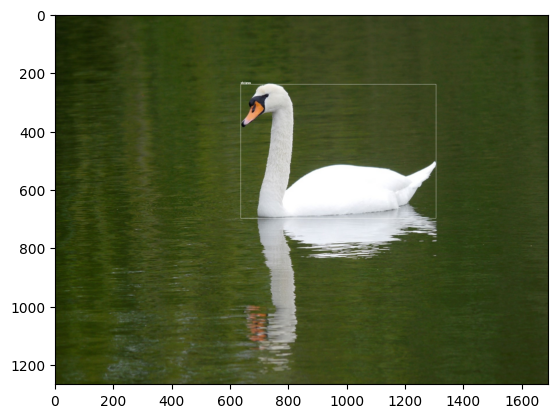

In [11]:
class_id_to_name_mapping = dict(zip(class_name_to_id_mapping.values(), class_name_to_id_mapping.keys()))

def plot_bounding_box(image, annotation_list):
    annotations = np.array(annotation_list)
    w, h = image.size
    
    plotted_image = ImageDraw.Draw(image)

    transformed_annotations = np.copy(annotations)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h 
    
    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]
    
    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        plotted_image.rectangle(((x0,y0), (x1,y1)))
        
        plotted_image.text((x0, y0 - 10), class_id_to_name_mapping[(int(obj_cls))])
    
    plt.imshow(np.array(image))
    plt.show()

# Get any random annotation file 
annotation_file = random.choice(annotations)
with open(annotation_file, "r") as file:
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    annotation_list = [[float(y) for y in x ] for x in annotation_list]

#Get the corresponding image file
image_file = f'{dataset_name}/images/' + annotation_file.split('/')[-1]
image_file = image_file.replace('txt', 'jpg')
print(image_file)
assert os.path.exists(image_file)

#Load the image
image = Image.open(image_file)

#Plot the Bounding Box
plot_bounding_box(image, annotation_list)

Разбиение данные на train/valid/test

In [12]:
# Read images and annotations
dir_input_img = f'{dataset_name}/images'
!mkdir annotations
dir_output_img = f'{dataset_name}/labels'


images = [os.path.join(dir_input_img, x) for x in os.listdir(dir_input_img)]
annotations = [os.path.join(dir_output_img, x) for x in os.listdir(dir_output_img) if x[-3:] == "txt"]

images.sort()
annotations.sort()

# Split the dataset into train-valid-test splits 
train_images, val_images, train_annotations, val_annotations = train_test_split(images, annotations, test_size = 0.05, random_state = 1)
val_images, test_images, val_annotations, test_annotations = train_test_split(val_images, val_annotations, test_size = 0.45, random_state = 1)

In [13]:
print(len(train_images), len(val_images), len(test_images))

8585 248 204


In [14]:
!mkdir data
!mkdir data/images
!mkdir data/annotations
!mkdir data/images/train data/images/val data/images/test data/annotations/train data/annotations/val data/annotations/test

In [15]:
def move_files_to_folder(list_of_files, destination_folder):
    for f in list_of_files:
        try:
            shutil.copy(f, destination_folder)
        except:
            print(f)
            assert False

# Move the splits into their folders
move_files_to_folder(train_images, '/kaggle/working/data/images/train')
move_files_to_folder(val_images, '/kaggle/working/data/images/val/')
move_files_to_folder(test_images, '/kaggle/working/data/images/test/')
move_files_to_folder(train_annotations, '/kaggle/working/data/annotations/train/')
move_files_to_folder(val_annotations, '/kaggle/working/data/annotations/val/')
move_files_to_folder(test_annotations, '/kaggle/working/data/annotations/test/')

In [16]:
os.listdir('annotations')

[]

In [17]:
!mv /kaggle/working/data/annotations /kaggle/working/data/labels

## Обучение модели

In [18]:
data_yaml = {
    'train': '/kaggle/working/data/images/train/',
    'val':  '/kaggle/working/data/images/val/',
    'test': '/kaggle/working/data/images/test/',
    'nc': 3,
    'names': ["klikun","small", "shipun"]
}

with open('data.yaml', 'w') as f:
    yaml.dump(data_yaml, f)

In [19]:
MODEL_NAME = 'yolov8l'

In [ ]:
#shutil.rmtree('/kaggle/working/runs')


model = YOLO(f'{MODEL_NAME}.pt')
#model = YOLO('runs/detect/train/weights/best.pt')
model.train(
    data='/kaggle/working/data.yaml',
    device=0,
    pretrained=False,
    val=True,
    seed=1,

    epochs=250,
    imgsz=640,

    optimizer='SGD',
    lr0=0.01,
    lrf=0.01,
    momentum=0.937,
    weight_decay=0.0005,
    warmup_epochs=3.0,
    warmup_momentum=0.8,
    warmup_bias_lr=0.1,
    dropout=0.3,


    hsv_h=0.015,  # image HSV-оттенок augmentation (fraction)
    hsv_s=0.4,  # image HSV-насыщение augmentation (fraction)
    hsv_v=0.4,  # image HSV-Value augmentation (fraction)
    degrees=10,  # поворот на угол (+/- deg)
    translate=0.0,  # image translation (+/- fraction) хз что это
    scale=0.1,  # приближение (+/- gain)
    shear=0.0,  # искажение изображения (+/- deg)
    perspective=0.0,  # искажение перпективы (+/- fraction), range 0-0.001
    flipud=0.0,  # переворот up-down (probability)
    fliplr=0.5,  # переворот left-right (probability)
    mosaic=0.95,  # объединение 4 изображений в одно и детекция (probability)
    mixup=0.0,  # наслоение изображений друг на друга.
    copy_paste=0.0,  # segment copy-paste (probability)
)

100%|██████████| 83.7M/83.7M [00:01<00:00, 64.1MB/s]
Ultralytics YOLOv8.0.105 🚀 Python-3.10.10 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
yolo/engine/trainer: task=detect, mode=train, model=yolov8l.pt, data=/kaggle/working/data.yaml, epochs=250, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=1, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=0, resume=False, amp=True, overlap_mask=True, mask_ratio=4, dropout=0.3, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
100%|██████████| 6.23M/6.23M [00:00<00:00, 119MB/s]
AMP: checks passed ✅
optimizer: SGD(lr=0.01) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias
train: Scanning /kaggle/working/data/labels/train... 8585 images, 3 backgrounds, 2 corrupt: 100%|██████████| 8585/8585 [00:05<00:00, 1519.09it/s]
train: WARNING ⚠️ /kaggle/working/data/images/train/2989.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      1.068]
train: WARNING ⚠️ /kaggle/working/data/images/train/3001.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      1.056]
train: New cache created: /kaggle/working/data/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))
val: Scanning /kaggle/working/data/labels/val... 248 images, 0 backgrounds, 0 corr

In [21]:
!zip -r -q model.zip /kaggle/working/runs/detect/train/weights/best.pt

<a href="./model.zip"> Download File </a>

## Валидация и предсказание

In [ ]:
os.listdir('runs/detect')

In [ ]:
# from utils.plots import plot_results
# plot_results('path/to/results.csv')  # plot 'results.csv' as 'results.png'

In [22]:
model = YOLO('runs/detect/train/weights/best.pt')
metrics = model.val(data='/kaggle/working/data.yaml')
print(metrics.box.maps)

Ultralytics YOLOv8.0.105 🚀 Python-3.10.10 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
Model summary (fused): 268 layers, 43608921 parameters, 0 gradients
val: Scanning /kaggle/working/data/labels/val.cache... 248 images, 0 backgrounds, 0 corrupt: 100%|██████████| 248/248 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.48it/s]
                   all        248        386      0.924      0.843      0.934      0.848
                klikun        248        159      0.864      0.843       0.92      0.802
                 small        248        131      0.963      0.806      0.929      0.841
                shipun        248         96      0.944       0.88      0.952      0.901
Speed: 0.6ms preprocess, 17.7ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to runs/detect/val


[    0.80167     0.84122     0.90141]


In [ ]:
results = model('/kaggle/working/data/images/test', verbose=False)

# names = model.names
# for r in results:
#     print()
#     for c in r.boxes.cls:
#         print(names[int(c)])

In [ ]:
img = results[300].plot()
plt.imshow(img)

In [ ]:
img = results[300].plot()
plt.imshow(img)

In [ ]:
img = results[300].plot()
plt.imshow(img)

In [ ]:
img = results[300].plot()
plt.imshow(img)

# Способ 2: поиск bird и классификация

In [ ]:
MODEL_NAME = 'yolov5x'

In [ ]:
model = YOLO(f'{MODEL_NAME}.pt')

In [ ]:
imgs = [
    'https://kartinkin.net/pics/uploads/posts/2022-07/1658266961_3-kartinkin-net-p-lebed-klikun-zhivotnie-krasivo-foto-3.jpg',
    'https://ufabirds.ru/wp-content/uploads/2020/06/6.Лебедь-шипун-29.04.20-Уфа-фото-Губиной-Т.В..jpg'
]

In [ ]:
results = model(imgs)

In [ ]:
img = results[0].plot()
plt.imshow(img)

In [ ]:
img = results[1].plot()
plt.imshow(img)

Получение областей, в которых находятся лебеди

In [ ]:
def crop_img(box):
    dh, dw = box.orig_shape
    dh, dw = dh.item(), dw.item()
    print(dh, dw)

    xywh = box.xywh[0]
    print(xywh)
    x,y,w,h = xywh[0], xywh[1], xywh[2], xywh[3]

    x,y,w,h = int(x*dw), int(y*dh), int(w*dw), int(h*dh)

    print(x, y, w, h)

    imgCrop = img[y:y+h,x:x+w]
    return imgCrop

In [ ]:
for box in results[0].boxes:
    print()
    print()
    plt.imshow(crop_img(box))
    print(box)

# Способ 3: Сегментация

In [ ]:
MODEL_NAME = 'yolov8n-seg'

In [ ]:
model = YOLO(f'{MODEL_NAME}.pt')

In [ ]:
results = model('https://ufabirds.ru/wp-content/uploads/2020/06/6.Лебедь-шипун-29.04.20-Уфа-фото-Губиной-Т.В..jpg')

In [ ]:
img = results[0].plot()
plt.imshow(img)

In [ ]:
from PIL import Image # (pip install Pillow)


def create_sub_masks(mask_image):
    width, height = mask_image.size

    # Initialize a dictionary of sub-masks indexed by RGB colors
    sub_masks = {}
    for x in range(width):
        for y in range(height):
            # Get the RGB values of the pixel
            pixel = mask_image.getpixel((x,y))[:3]

            # If the pixel is not black...
            if pixel != (0, 0, 0):
                # Check to see if we've created a sub-mask...
                pixel_str = str(pixel)
                sub_mask = sub_masks.get(pixel_str)
                if sub_mask is None:
                   # Create a sub-mask (one bit per pixel) and add to the dictionary
                    # Note: we add 1 pixel of padding in each direction
                    # because the contours module doesn't handle cases
                    # where pixels bleed to the edge of the image
                    sub_masks[pixel_str] = Image.new('1', (width+2, height+2))

                # Set the pixel value to 1 (default is 0), accounting for padding
                sub_masks[pixel_str].putpixel((x+1, y+1), 1)

    return sub_masks

# Преобразование mask to box (txt)

In [ ]:
def convert_to_yolov5(boxes, image_size, filename, class_id):
    print_buffer = []
    
    # For each bounding box
    for box in boxes:
        
        # Transform the bbox co-ordinates as per the format required by YOLO v5
        b_center_x = (box[0] + box[2]) / 2 
        b_center_y = (box[1] + box[3]) / 2
        b_width    = (box[2] - box[0])
        b_height   = (box[3] - box[1])
        
        # Normalise the co-ordinates by the dimensions of the image
        image_c, image_h, image_w = image_size 
        b_center_x /= image_w 
        b_center_y /= image_h 
        b_width    /= image_w 
        b_height   /= image_h 
        
        #Write the bbox details to the file 
        print_buffer.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(class_id, b_center_x, b_center_y, b_width, b_height))
        
    # Name of the file which we have to save 
    save_file_name = filename.replace("png", "txt")
    
    # Save the annotation to disk
    print("\n".join(print_buffer), file=open(save_file_name, "w"))

In [ ]:
def create_txt(filename, class_id, dir_save):

    img_path = os.path.join(ASSETS_DIRECTORY, f"{dir_class}/images/{filename}")
    mask_path = os.path.join(ASSETS_DIRECTORY, f"{dir_class}/masks/{filename.replace('jpg', 'png')}").replace('images', 'masks')
    
    print(img_path, mask_path, 123)
    img = read_image(img_path)
    mask = read_image(mask_path)
    
    obj_ids = torch.unique(mask)

    obj_ids = obj_ids[1:]

    masks = mask == obj_ids[:, None, None]

#     drawn_masks = []
#     for mask in masks:
#         print(img.shape, mask.shape)
#         drawn_masks.append(draw_segmentation_masks(img, mask, alpha=0.8, colors="blue"))

    boxes = masks_to_boxes(masks)

    convert_to_yolov5(boxes, img.shape, f"result/{dir_save}/{filename.replace('jpg', 'png')}", class_id)

#     drawn_boxes = draw_bounding_boxes(img, boxes, colors="red", width=10)
#     show(drawn_boxes)

In [ ]:
import os
from tqdm import tqdm
import numpy as np
import torch
import matplotlib.pyplot as plt

import torchvision.transforms.functional as F


ASSETS_DIRECTORY = "/kaggle/input/digital-swan"

plt.rcParams["savefig.bbox"] = "tight"


def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])


from torchvision.io import read_image
from torchvision.utils import draw_segmentation_masks
from torchvision.ops.boxes import masks_to_boxes
from torchvision.utils import draw_bounding_boxes


!mkdir result
!mkdir result/klikun0
!mkdir result/small1
!mkdir result/shipun2

for id_class, dir_class in enumerate(os.listdir(ASSETS_DIRECTORY)):
    print(dir_class)
    
    for filename in tqdm(os.listdir(f'{ASSETS_DIRECTORY}/{dir_class}/images')):
        
        if filename != 'depositphotos_293346084-stock-photo-bewicks-swan-cygnus-columbianus.jpg':
            continue
        
        create_txt(filename, id_class, dir_class)

In [ ]:
!zip -r -q file.zip /kaggle/working/result

<a href="./file.zip"> Download File </a>